In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
df = pd.read_csv('Training_set.csv')
print(df.head())
print(df['label'].value_counts())

      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
label
MOURNING CLOAK         105
SLEEPY ORANGE           82
CRECENT                 82
ORANGE TIP              81
MONARCH                 78
                      ... 
YELLOW SWALLOW TAIL     56
GOLD BANDED             54
MALACHITE               53
ZEBRA LONG WING         52
CRIMSON PATCH           47
Name: count, Length: 75, dtype: int64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   5000 non-null   object
 1   label      5000 non-null   object
 2   filepath   5000 non-null   object
 3   label_enc  5000 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 136.8+ KB


In [4]:
df.describe()

,label_enc
count,5000.000000
mean,36.678200
std,21.423829
min,0.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,74.000000


In [ ]:
df['filepath'] = df['filename'].apply(lambda x: os.path.join('train', 'train', x))

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['label_enc'], random_state=42)

In [44]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    shear_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label_enc',
    target_size=img_size, batch_size=batch_size,
    class_mode='raw'
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label_enc',
    target_size=img_size, batch_size=batch_size,
    class_mode='raw'
)

Found 4250 validated image filenames.
Found 750 validated image filenames.


In [45]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = True  # Fine-tune entire model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [46]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [47]:
history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.0355 - loss: 5.0080 - val_accuracy: 0.0120 - val_loss: 4.3760 - learning_rate: 1.0000e-04
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.2267 - loss: 3.3022 - val_accuracy: 0.0267 - val_loss: 4.3894 - learning_rate: 1.0000e-04
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.4796 - loss: 2.0645 - val_accuracy: 0.1173 - val_loss: 3.9468 - learning_rate: 1.0000e-04
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.6364 - loss: 1.4527 - val_accuracy: 0.4560 - val_loss: 2.1122 - learning_rate: 1.0000e-04
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.7125 - loss: 1.1016 - val_accuracy: 0.2200 - val_loss: 3.3209 - learning_rate: 1.0000e-04
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7753 - loss: 0.8587 - val_accuracy: 0.5360 - val_loss: 1.8594 - learning_rate: 1.0000e-04
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - acc

In [48]:
test_files = sorted(glob(os.path.join('test', 'test', '*.jpg')))
test_df = pd.DataFrame({'filepath': test_files})

test_gen = val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col=None,
    target_size=img_size, batch_size=batch_size,
    class_mode=None, shuffle=False
)

preds = model.predict(test_gen)
pred_labels = le.inverse_transform(np.argmax(preds, axis=1))

submission = pd.DataFrame({
    'ID': [os.path.basename(f) for f in test_files],
    'Label': pred_labels
})

submission.to_csv("submission.csv", index=False)
print("✅ Saved submission.csv")

Found 1499 validated image filenames.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step
✅ Saved submission.csv


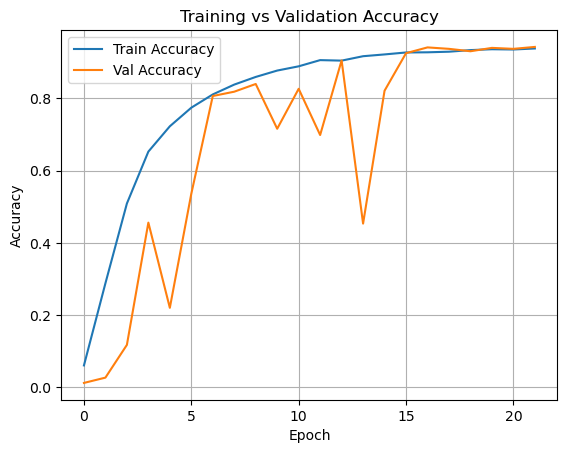

In [49]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Training vs Validation Accuracy')
plt.show()
